<a href="https://colab.research.google.com/github/pao0318/Tensorflow2-Imperial-College-London/blob/main/ScheduleLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes
df=load_diabetes()


In [3]:
# Save the input and target variables
from sklearn.model_selection import train_test_split
data=df['data']
targets=df['target']

In [13]:
# Normalise the target data (this will make clearer training curves)
X_train, X_test, y_train, y_test=train_test_split(data,targets,test_size=0.1)


In [14]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = tf.keras.Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)        
])

In [19]:
    
model.compile(loss='mse', optimizer="adam", metrics=['mae'])


#### Defining a custom callback


In [20]:
class LossandMetricCallback(tf.keras.callbacks.Callback):

  def on_train_batch_end(seld,batch,logs=None):
    if batch %2 ==0:
      print('\n After Training batch {} the loss is {:7.2f}.'.format(batch, logs['loss']))

  def on_test_batch_end(self,batch,logs=None):
    print('\n After Test batch {} the loss is {:7.2f}.'.format(batch, logs['loss']))

  def on_epoch_end(self, epoch, logs=None):
        print('Epoch {}: Average loss is {:7.2f}, mean absolute error is {:7.2f}.'.format(epoch, logs['loss'], logs['mae']))
    
    # Notify the user when prediction has finished on each batch
  def on_predict_batch_end(self,batch, logs=None):
        print("Finished prediction on batch {}!".format(batch))

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 18,305
Trainable params: 18,177
Non-trainable params: 128
________________________________________________

In [22]:
# Train the model, with some of the data reserved for validation


history = model.fit(X_train, y_train, epochs=20,
                    batch_size=100, callbacks=[ LossandMetricCallback()], verbose=False)


 After Training batch 0 the loss is 27724.82.

 After Training batch 2 the loss is 29383.82.
Epoch 0: Average loss is 29024.32, mean absolute error is  151.73.

 After Training batch 0 the loss is 29860.37.

 After Training batch 2 the loss is 28688.05.
Epoch 1: Average loss is 28871.69, mean absolute error is  151.26.

 After Training batch 0 the loss is 34070.75.

 After Training batch 2 the loss is 29057.19.
Epoch 2: Average loss is 28653.91, mean absolute error is  150.58.

 After Training batch 0 the loss is 22868.75.

 After Training batch 2 the loss is 27387.80.
Epoch 3: Average loss is 28335.93, mean absolute error is  149.64.

 After Training batch 0 the loss is 27318.24.

 After Training batch 2 the loss is 29136.04.
Epoch 4: Average loss is 27892.20, mean absolute error is  148.31.

 After Training batch 0 the loss is 27059.76.

 After Training batch 2 the loss is 27614.11.
Epoch 5: Average loss is 27284.83, mean absolute error is  146.49.

 After Training batch 0 the loss 

In [23]:
# Evaluate the model on the test set

model_eval=model.evaluate(X_test,y_test,batch_size=10,
                          callbacks=[LossandMetricCallback()],verbose=False)


 After Test batch 0 the loss is 12344.42.

 After Test batch 1 the loss is 17259.92.

 After Test batch 2 the loss is 14410.78.

 After Test batch 3 the loss is 15371.96.

 After Test batch 4 the loss is 15490.94.


#### Plot the learning curves

In [27]:

model_pred = model.predict(X_test, batch_size=10,
                           callbacks=[LossandMetricCallback()], verbose=False)

Finished prediction on batch 0!
Finished prediction on batch 1!
Finished prediction on batch 2!
Finished prediction on batch 3!
Finished prediction on batch 4!


In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

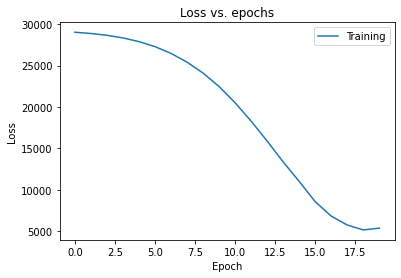

In [29]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [42]:
lr_schedule=[(4,0.03),(7,0.02),(11,0.05),(7,0.02)]
def get_new_epoch_lr(epoch,lr):
  epoch_in_schd=[i for i in range(len(lr_schedule)) if lr_schedule[i][0]==int(epoch)]
  if len(epoch_in_schd)>0:
    return lr_schedule[epoch_in_schd[0]][1]
  else:
    return lr
        
      


In [43]:
# Define the custom callback

class LRScheduler(tf.keras.callbacks.Callback):
    
    def __init__(self, new_lr):
        super(LRScheduler, self).__init__()
        # Add the new learning rate function to our callback
        self.new_lr = new_lr

    def on_epoch_begin(self, epoch, logs=None):
        # Make sure that the optimizer we have chosen has a learning rate, and raise an error if not
        if not hasattr(self.model.optimizer, 'lr'):
              raise ValueError('Error: Optimizer does not have a learning rate.')
                
        # Get the current learning rate
        curr_rate = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        
        # Call the auxillary function to get the scheduled learning rate for the current epoch
        scheduled_rate = self.new_lr(epoch, curr_rate)

        # Set the learning rate to the scheduled learning rate
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_rate)
        print('Learning rate for epoch {} is {:7.3f}'.format(epoch, scheduled_rate))


In [44]:

new_model = tf.keras.Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)        
])

In [45]:
new_model.compile(loss='mse',
                optimizer="adam",
                metrics=['mae', 'mse'])

In [46]:
new_history = new_model.fit(X_train,y_train, epochs=20,
                            batch_size=100, callbacks=[LRScheduler(get_new_epoch_lr)], verbose=False)

Learning rate for epoch 0 is   0.001
Learning rate for epoch 1 is   0.001
Learning rate for epoch 2 is   0.001
Learning rate for epoch 3 is   0.001
Learning rate for epoch 4 is   0.030
Learning rate for epoch 5 is   0.030
Learning rate for epoch 6 is   0.030
Learning rate for epoch 7 is   0.020
Learning rate for epoch 8 is   0.020
Learning rate for epoch 9 is   0.020
Learning rate for epoch 10 is   0.020
Learning rate for epoch 11 is   0.050
Learning rate for epoch 12 is   0.050
Learning rate for epoch 13 is   0.050
Learning rate for epoch 14 is   0.050
Learning rate for epoch 15 is   0.050
Learning rate for epoch 16 is   0.050
Learning rate for epoch 17 is   0.050
Learning rate for epoch 18 is   0.050
Learning rate for epoch 19 is   0.050
